In [ ]:
#Import neccesary libraries

import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Using reference code: https://www.kaggle.com/taniaj/cryptocurrency-predictions-with-arima

In [ ]:
#Load the data
from google.colab import files # Use to load data on Google Colab
uploaded = files.upload() # Use to load data on Google Colab

Saving BTC-USD.csv to BTC-USD.csv


In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('BTC-USD.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [ ]:
btc = df
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

Stationarity check and Seasonal decomposition

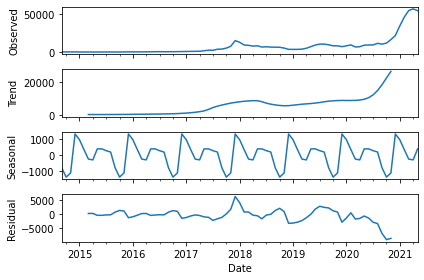

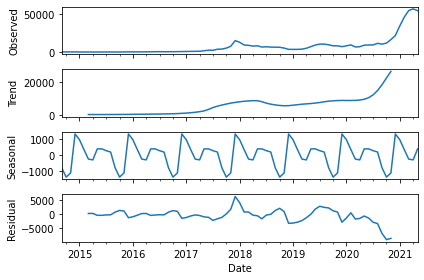

In [ ]:
seasonal_decompose(btc_month.Close).plot()


In [ ]:
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])
#p = a float datatype
#The p-value indicates that series is not stationary with 64.52% confidence.

Dickey–Fuller test: p=0.645235


Box-Cox Transformation
It is a set of transformation done to make a process stationary and coerce normality.

In [ ]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

#The p-value indicates that series is not stationary with 94.35% confidence. Not nice.
#We want p value < 0.05 to achieve stationarity of timeseries

Dickey–Fuller test: p=0.943562


Differencing 
When building models to forecast time series data (like ARIMA), another pre-processing step is differencing the data (calculating sequentially xt−xt−1) until we get to a point where the series is stationary. 

In [ ]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])
#The p-value indicates that series is still not stationary.

Dickey–Fuller test: p=0.213300


In [ ]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])
#3: is there because first 3 values won't come as there is no 3 values before the first one.

Dickey–Fuller test: p=0.024303


The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

Regular differentiation 
Sometimes it may be necessary to difference the data a second time to obtain a stationary time series, which is referred to as second order differencing.

Dickey–Fuller test: p=0.000007


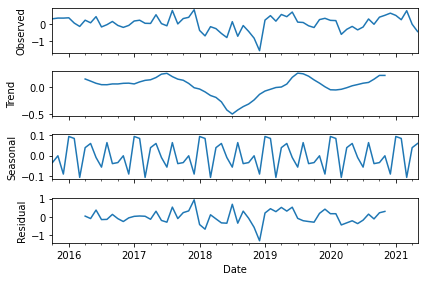

In [ ]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

plt.show()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

##Autocorrelation 
Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. It is done to identify presence of AR and MA components in the residuals.

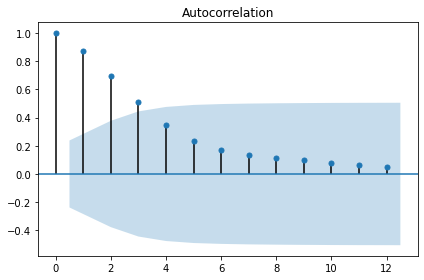

In [ ]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()


There is a positive correlation with the first 10 lags that is perhaps significant for the first 3-4 lags.

A good starting point for the AR parameter of the model may be 3.

Lets try out autocorrelation on the differences...

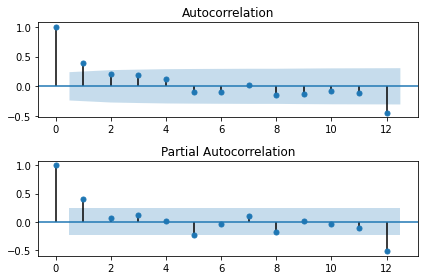

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models.

There may be a seasonal component available in the residuals at the lags of quarters (3 months) represented by spikes at these intervals. But probably not significant.

##ARIMA Model 
AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:

p - the number of lag observations to include in the model, or lag order. (AR)

d - the number of times that the raw observations are differenced, or the degree of differencing. (I)

q - the size of the moving average window, also called the order of moving average.(MA)

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates to not use that element of the model.

##Parameter Selection
We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [ ]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
3     (1, 0)  15.957060
4     (1, 1)  17.737347
1     (0, 1)  17.794639
6     (2, 0)  17.874772
5     (1, 2)  18.720389


Sometimes AIC values can be negative as well, unlike our present case, but not to worry as we always consider absolute positive values of AIC.

In [ ]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                   81
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  -5.979
Date:                Thu, 03 Jun 2021   AIC                             15.957
Time:                        22:02:53   BIC                             20.721
Sample:                    09-30-2014   HQIC                            17.867
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4197      0.072      5.810      0.000       0.278       0.561
sigma2         0.0678      0.010      7.062      0.000       0.049       0.087
Ljung-Box (Q):                       42.34   Jarque-

##Analysis of Results 
The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

In [ ]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


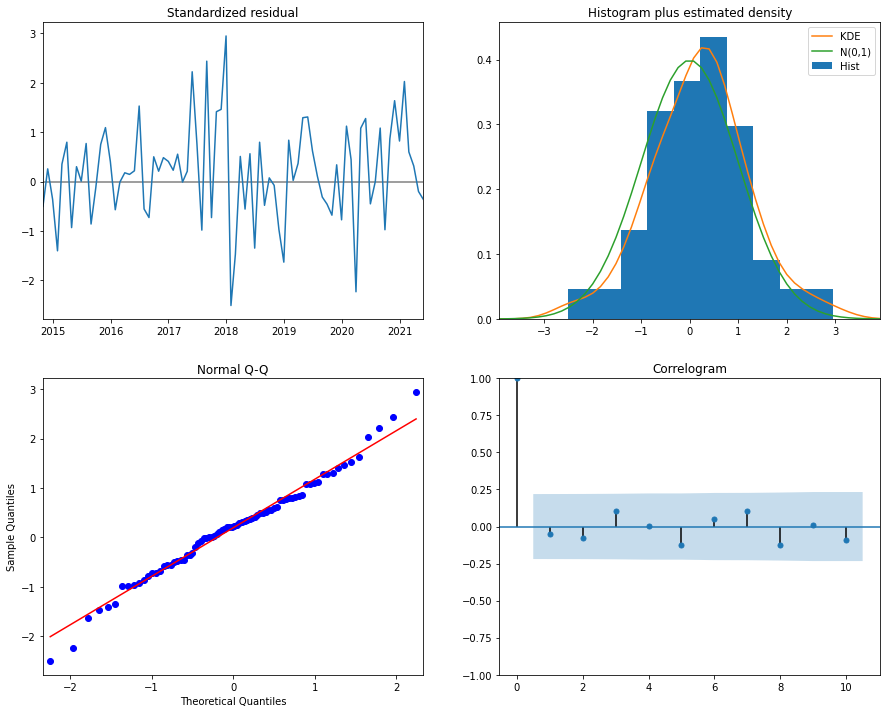

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the histogram (top right), the KDE line should follow the N(0,1) line (normal distribution with mean 0, standard deviation 1) closely. This is an indication whether the residuals are normally distributed or not.

In the Q-Q-plot the ordered distribution of residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is an indication whether the residuals are normally distributed.

The standardized residual plot doesn't display any obvious seasonality. 
This is confirmed by the autocorrelation plot, which shows that the time series residuals have low correlation with lagged versions of itself.

Conclusion: We may consider trying to standardise the distribution further. But lets go ahead and do a prediction anyway...

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

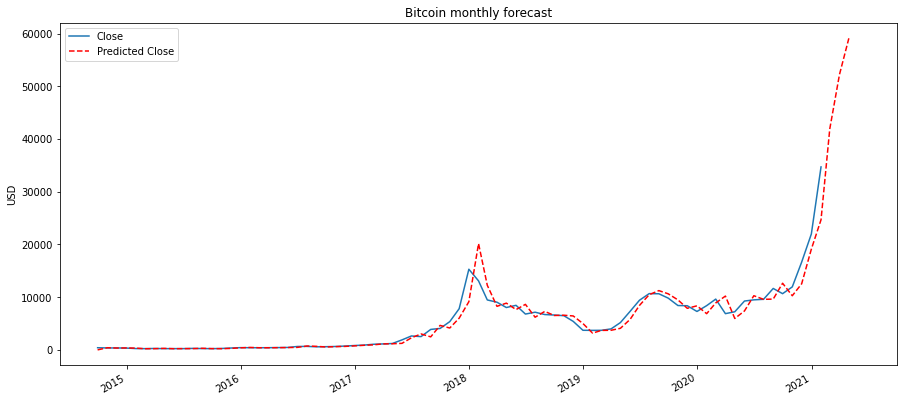

In [ ]:
# Prediction
btc_month_pred = btc_month[['Close']]

date_list = [datetime(2021, 1, 31), datetime(2021, 2, 28), datetime(2021, 3, 31), datetime(2021, 4, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 9, 30), end=datetime(2021, 4, 30)), lmbda)
#We don't begin with start data as it is monthly spaced data we are considering.


plt.figure(figsize=(15,7))
btc_month_pred.Close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

In [ ]:
#ARIMA errors

# Compute the root mean square error
rmse = np.sqrt(((btc_month_pred.forecast - btc_month_pred.Close) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))





Mean Squared Error: 1963.16


In [ ]:
from sklearn.metrics import mean_absolute_error

abc = btc_month_pred.Close - btc_month_pred.forecast
abc = abs(abc)
abc = abc[~np.isnan(abc)]
from statistics import mean
abc = mean(abc)
print(abc)
#print(mean_absolute_error) 

1031.7950201104456


In [ ]:
from sklearn.metrics import r2_score

forecast = btc_month_pred['2020-01-01':'2021-01-01'].forecast
Close_1 = btc_month_pred['2020-01-01':'2021-01-01'].Close




from scipy.stats import pearsonr
corr, _ = pearsonr(Close_1, forecast)
r_squared = corr**2
print(r_squared)

0.7695850519022557


SARIMAX Model 
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

We didn't expect the bitcoin data to display any seasonality but apparently it does display slight seasonality. So lets try to improve the model by using SARIMA.

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

I have tried out this model with yearly and quarterly periods (toggle the commented out lines to see 12-month seasonal).

In [ ]:
## SARIMAX
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
19  (1, 0, 0, 1)  30.075300
7   (0, 1, 0, 1)  30.524070
21  (1, 0, 1, 1)  31.736580
9   (0, 1, 1, 1)  32.018289
25  (1, 1, 0, 1)  32.068071
                                 Statespace Model Results                                
Dep. Variable:                         close_box   No. Observations:                   81
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 4)   Log Likelihood                 -12.038
Date:                           Thu, 03 Jun 2021   AIC                             30.075
Time:                                   22:03:14   BIC                             37.068
Sample:                               09-30-2014   HQIC                            32.870
                                    - 05-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

In [ ]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


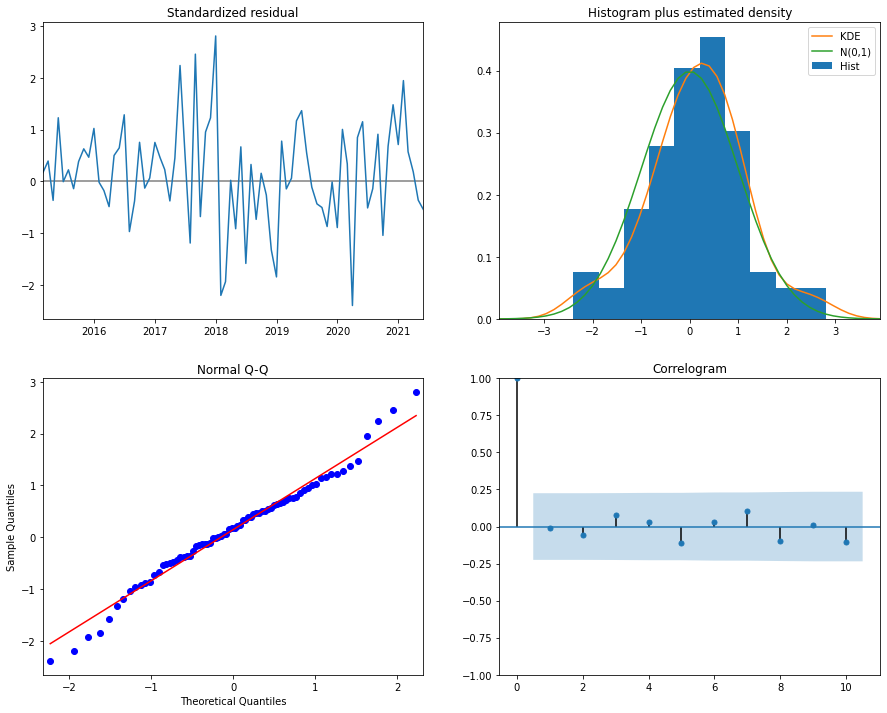

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000000


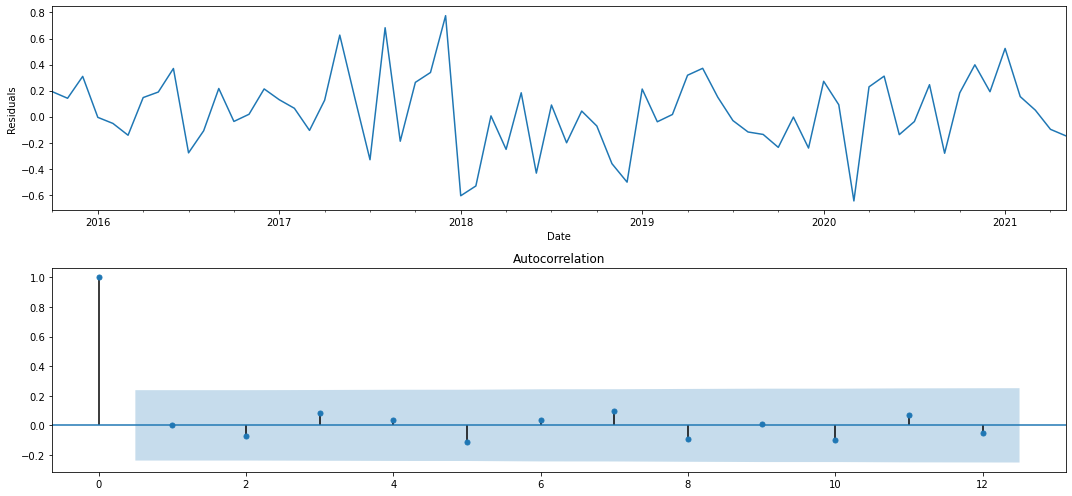

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

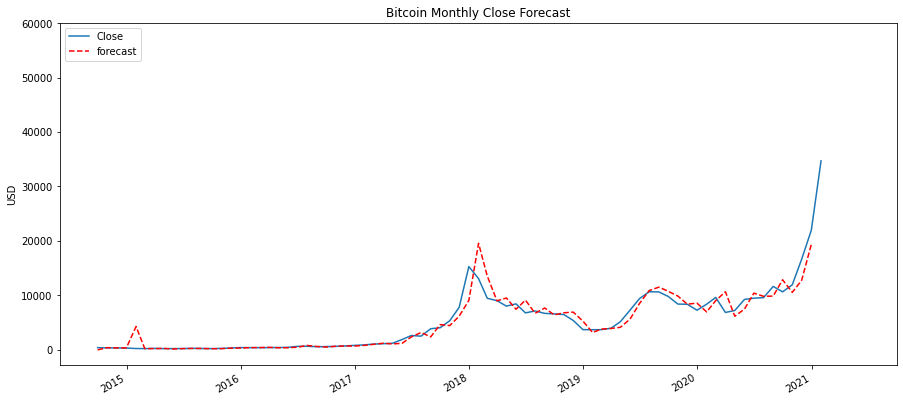

In [ ]:
# Prediction with SARIMAX
btc_month2 = btc_month[['Close']]
date_list = [datetime(2021, 1, 31), datetime(2021, 2, 28), datetime(2021, 3, 31), datetime(2021, 4, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
btc_month2.Close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

In [ ]:
##VALIDATION

#A simple indicator of how accurate out forecast is is the root mean square error (RMSE). 
#So lets calcualte RMSE for the one-step ahead predictions starting from 2019, through to the end of Apr 2021.

y_forecasted = btc_month2.forecast
y_truth = btc_month2['2020-01-01':'2021-01-01'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))



##Mean Squared Error: 2114.81 for y_truth = btc_month2['2020-01-01':'2021-01-01'].Close
##Mean Squared Error: 1345.96 for y_truth = btc_month2['2015-01-01':'2017-01-01'].Close

Mean Squared Error: 2114.81


In [ ]:
from sklearn.metrics import mean_absolute_error

abc = btc_month2.Close - btc_month2.forecast
abc = abs(abc)
abc = abc[~np.isnan(abc)]
from statistics import mean
abc = mean(abc)
print(abc)
#print(mean_absolute_error) 

915.300164477418


In [ ]:
from sklearn.metrics import r2_score

forecast = btc_month2['2020-01-01':'2021-01-01'].forecast





from scipy.stats import pearsonr
corr, _ = pearsonr(y_truth, forecast)

r_squared = corr**2
print(r_squared)

0.7582203696011817


In [ ]:
(ab)